# Revenue

### Imports

In [16]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score

### Datadet and Preparation

In [160]:
df = pd.read_pickle('../training_dataset_task3/task_3_training_e8da4715deef7d56_f8b7378_pandas.pkl').reset_index()

# only low and mid level features in X
X = df.loc[:, 'essentia_dissonance_mean':'mirtoolbox_roughness_pct_90']
y = df['quadrant']

In [161]:
from sklearn.model_selection import cross_val_score

# add segment ID to feature space
X['segment_id'] = df['segment_id']

# pick segment 26 for final evaluation
final_test_X = X[X['segment_id']==26]
final_test_y = y[X['segment_id']==26]

# drop segment ID column
final_test_X = final_test_X.drop(['segment_id'], axis=1)


# drop segment 26 from dataset to use for final evaluation, y first
y = y.drop(X[X['segment_id']==26].index, axis=0)
X = X.drop(X[X['segment_id']==26].index, axis=0)

# drop segment ID column
X = X.drop(['segment_id'], axis=1)


# preprocess dataset
X_std = StandardScaler().fit_transform(X)
X = pd.DataFrame(X_std, columns=X.columns)




# Split in Training and Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train.shape, X_test.shape, final_test_X.shape

((1471, 169), (725, 169), (86, 169))

### Classifiers

In [44]:
def cross_val(model, kf=10):
    val = cross_val_score(estimator=model, X=X, y=y, cv=kf).mean()
    return val

In [45]:
best_random = RandomForestClassifier(bootstrap=False, max_depth=90, min_samples_leaf=2, min_samples_split=5, n_estimators=200)
best_random.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=90, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=200)

In [46]:
cross_val(best_random)

0.45037152345371523

In [60]:
brf_fin = best_random.predict(final_test_X)
hm = brf_fin - np.array(final_test_y) == 0
sc = 0
for i in hm:
    if i == True:
        sc +=1
sc/len(final_test_y)

preds = best_random.predict(X_test)
actual = np.array(y_test)

# preds == actual

### Matrix Gain

In [28]:
gain = np.array([[5, -5, -5, 2], [-5, 10, 2, -5], [-5, 2, 10, -5], [2, -5, -2, 5]])
# gain

In [73]:
def revenue(clf, X=X_test, y=y_test):
    rev = 0
    preds = clf.predict(X)
    actual = np.array(y)
        
    for p in range(len(preds)):
        if preds[p] == 2: # prediction is angry
            if actual[p] == 2: # actually angry
                rev += 10 
            if actual[p] == 1: # actually happy
                rev -= 5
            if actual[p] == 3: # actually sad
                rev += 2
            if actual[p] == 4: # actually relaxed
                rev -= 5
                
        if preds[p] == 1: # prediction is happy
            if actual[p] == 1: # actually happy
                rev += 5
            if actual[p] == 2: # actually angry
                rev -= 5
            if actual[p] == 3: # actually sad
                rev -= 5
            if actual[p] == 4: # actually relaxed
                rev += 2
                
        if preds[p] == 3: # prediction is sad
            if actual[p] == 1: # actually happy
                rev -= 5
            if actual[p] == 2: # actually angry
                rev += 2
            if actual[p] == 3: # actually sad
                rev += 10
            if actual[p] == 4: # actually relaxed
                rev -= 2
                
        if preds[p] == 4: # prediction is relaxed
            if actual[p] == 1: # actually happy
                rev += 2
            if actual[p] == 2: # actually angry
                rev -= 5
            if actual[p] == 3: # actually sad
                rev -= 5
            if actual[p] == 4: # actually relaxed
                rev += 5
    
    return rev

In [75]:
# Revenue on X_test, y_test
revenue(best_random)

1926

In [76]:
# Revenue on segment 26
revenue(best_random, final_test_X, final_test_y)

-87

___

# Search

In [79]:
from pprint import pprint

In [80]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [115]:
scores = [0]
clfs = []

In [116]:
tries = 10
for i in range(tries):
    clf = RandomForestClassifier(n_estimators=n_estimators[np.random.randint(len(n_estimators))],
                                min_samples_split=min_samples_split[np.random.randint(len(min_samples_split))],
                                max_depth=max_depth[np.random.randint(len(max_depth))],
                                max_features=max_features[np.random.randint(len(max_features))],
                                min_samples_leaf=min_samples_leaf[np.random.randint(len(min_samples_leaf))],
                                bootstrap=bootstrap[np.random.randint(len(bootstrap))]
                                )
    print(clf)
    clf.fit(X_train, y_train)
    score = revenue(clf)
    print(score, '\n')
    for i in scores:
        if score > i:
            clfs.append(f'{clf}, "-->", {score}')
            scores.append(score)

RandomForestClassifier(bootstrap=False, max_depth=110, max_features='sqrt',
                       min_samples_split=10, n_estimators=1600)
1974
RandomForestClassifier(bootstrap=False, max_depth=110, n_estimators=1800)
1991
RandomForestClassifier(bootstrap=False, max_depth=100, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=800)
1880
RandomForestClassifier(max_depth=60, min_samples_leaf=2, n_estimators=1000)
1957
RandomForestClassifier(max_depth=110, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=1000)
1945
RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_split=10,
                       n_estimators=1200)
1772
RandomForestClassifier(bootstrap=False, max_depth=20, max_features='sqrt',
                       min_samples_split=10, n_estimators=1200)
2006
RandomForestClassifier(bootstrap=False, max_depth=90, max_features='sqrt',
                       min_samples_l

In [117]:
most_rev = max(scores)
max_index=scores.index(most_rev)
clfs[max_index]

'RandomForestClassifier(bootstrap=False, max_depth=20, max_features=\'sqrt\',\n                       min_samples_split=10, n_estimators=1200), "-->", 2006'

In [118]:
###
rfb_rev = RandomForestClassifier(bootstrap=False, max_depth=20, max_features='sqrt', min_samples_split=10, n_estimators=1200)
rfb_rev.fit(X_train, y_train)

revenue(rfb_rev), revenue(rfb_rev, final_test_X, final_test_y)

(1964, -105)

In [120]:
#### less n_estimators
scores = [0]
clfs = []

10

In [121]:
tries = 10
for i in range(tries):
    clf = RandomForestClassifier(n_estimators=n_estimators[np.random.randint(5)],
                                min_samples_split=min_samples_split[np.random.randint(len(min_samples_split))],
                                max_depth=max_depth[np.random.randint(len(max_depth))],
                                max_features=max_features[np.random.randint(len(max_features))],
                                min_samples_leaf=min_samples_leaf[np.random.randint(len(min_samples_leaf))],
                                bootstrap=bootstrap[np.random.randint(len(bootstrap))]
                                )
    print(clf)
    clf.fit(X_train, y_train)
    score = revenue(clf)
    print(score, '\n')
    for i in scores:
        if score > i:
            clfs.append(f'{clf}, "-->", {score}')
            scores.append(score)

RandomForestClassifier(max_depth=110, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=400)
1868 

RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=200)
1902 

RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=1000)
1886 

RandomForestClassifier(max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=200)
1848 

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=4,
                       min_samples_split=5, n_estimators=400)
1871 

RandomForestClassifier(max_depth=60, max_features='sqrt', min_samples_split=10,
                       n_estimators=800)
1896 

RandomForestClassifier(max_depth=90, max_features='sqrt', n_estimators=400)
1936 

RandomForestClassifier(bootstrap=False, min_samples_leaf=4, n_estimators=1000)
1920 

RandomForestClassifier(boo

In [122]:
most_rev = max(scores)
max_index=scores.index(most_rev)
clfs[max_index]

'RandomForestClassifier(bootstrap=False, max_depth=100, max_features=\'sqrt\',\n                       n_estimators=600), "-->", 1943'

In [124]:
###
rfb_rev = RandomForestClassifier(bootstrap=False, max_depth=100, max_features='sqrt', n_estimators=600)
rfb_rev.fit(X_train, y_train)

(1939, 151)

In [151]:
tot_rev_y_test = 0
y_test = np.array(y_test)
for i in range(len(y_test)):
    if y_test[i] == 1:
        tot_rev_y_test += 5
    if y_test[i] == 2:
        tot_rev_y_test += 10
    if y_test[i] == 3:
        tot_rev_y_test += 10
    if y_test[i] == 4:
        tot_rev_y_test += 5

In [157]:
tot_rev_26 = 0
final_test_y = np.array(final_test_y)
for i in range(len(final_test_y)):
    if y_test[i] == 1:
        tot_rev_26 += 5
    if y_test[i] == 2:
        tot_rev_26 += 10
    if y_test[i] == 3:
        tot_rev_26 += 10
    if y_test[i] == 4:
        tot_rev_26 += 5

In [162]:
print(f'Revenue on X_test: {revenue(rfb_rev)}/{tot_rev_y_test}')
print(f'Revenue on Segment 26: {revenue(rfb_rev, final_test_X, final_test_y)}/465')

Revenue on X_test: 1939/5480
Revenue on Segment 26: 151/465


In [163]:
###
rev200 = RandomForestClassifier(bootstrap=False, max_depth=100, max_features='sqrt', n_estimators=200)
rev200.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=100, max_features='sqrt',
                       n_estimators=200)

In [164]:
print(f'Revenue on X_test: {revenue(rev200)}/{tot_rev_y_test}')
print(f'Revenue on Segment 26: {revenue(rev200, final_test_X, final_test_y)}/465')

Revenue on X_test: 2031/5480
Revenue on Segment 26: 38/465


In [203]:
rev300 = RandomForestClassifier(bootstrap=False, max_depth=100, max_features='sqrt', n_estimators=30)
rev300.fit(X_train, y_train)

print(f'Revenue on X_test: {revenue(rev300)}/{tot_rev_y_test}')
print(f'Revenue on Segment 26: {revenue(rev300, final_test_X, final_test_y)}/465')

Revenue on X_test: 1942/5480
Revenue on Segment 26: 34/465


In [204]:
rev400 = RandomForestClassifier(bootstrap=False, max_depth=100, max_features='sqrt', n_estimators=400)
rev400.fit(X_train, y_train)

print(f'Revenue on X_test: {revenue(rev400)}/{tot_rev_y_test}')
print(f'Revenue on Segment 26: {revenue(rev400, final_test_X, final_test_y)}/465')

Revenue on X_test: 1979/5480
Revenue on Segment 26: 110/465


In [168]:
import matplotlib.pyplot as plt

In [181]:
revens = []
for i in range(200,600,10):
    clf = RandomForestClassifier(bootstrap=False, max_depth=100, max_features='sqrt', n_estimators=i)
    clf.fit(X_train, y_train)
    revens.append(revenue(clf))

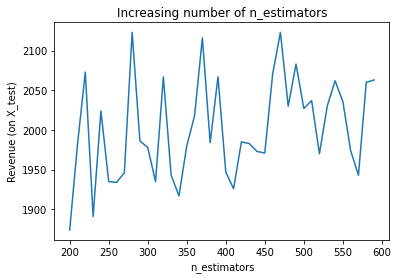

In [210]:
plt.plot(range(200,600,10), revens)
plt.title('Increasing number of n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Revenue (on X_test)')
plt.show()

In [207]:
most_rev = max(revens)
max_index=revens.index(most_rev)

most_rev, max_index

(2123, 8)

In [201]:
n = []
for i in range(200,600,10):
    n.append(i)
    
n_estimators=n[8]

In [215]:
rev280 = None
rev280 = RandomForestClassifier(bootstrap=False, max_depth=100, max_features='sqrt', n_estimators=n_estimators)
rev280.fit(X_train, y_train)

print(f'Revenue on X_test: {revenue(rev280)}/{tot_rev_y_test}')
print(f'Revenue on Segment 26: {revenue(rev280, final_test_X, final_test_y)}/465')

Revenue on X_test: 1979/5480
Revenue on Segment 26: 138/465
